# [IAPR 2020:][iapr2020] Lab 3 ‒  Classification

**Author:** Oganes Manasian, Maksim Kriukov, Henry Declety
**Due date:** 08.05.2020

[iapr2018]: https://github.com/LTS5/iapr-2018

## Extract relevant data
We first need to extract the `lab-03-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [1]:
import tarfile
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy import optimize

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-03-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

## Part 1
In this part, we will study classification based on the data available in the Matlab file `classification.mat` that you will under `lab-03-data/part1`.
There are 3 data sets in this file, each one being a training set for a given class.
They are contained in variables `a`, `b` and `c`.

**Note**: we can load Matlab files using the [scipy.io] module.

[scipy.io]: https://docs.scipy.org/doc/scipy/reference/io.html

In [2]:
import scipy.io

data_part1_path = os.path.join(data_base_path, data_folder, 'part1', 'classification.mat')
matfile = scipy.io.loadmat(data_part1_path)
a = matfile['a']
b = matfile['b']
c = matfile['c']

print(a.shape, b.shape, c.shape)

(200, 2) (200, 2) (200, 2)


### 1.1 Bayes method
Using the Bayes method, give the analytical expression of the separation curves between those three classes.
Do reasonable hypotheses about the distributions of those classes and estimate the corresponding parameters based on the given training sets.
Draw those curves on a plot, together with the training data.
For simplicity reasons, round the estimated parameters to the closest integer value.

Let's first plot provided sets. It will help us to make hypotheses about their distributions.

In [3]:
a_xy = list(zip(*a))
b_xy = list(zip(*b))
c_xy = list(zip(*c))

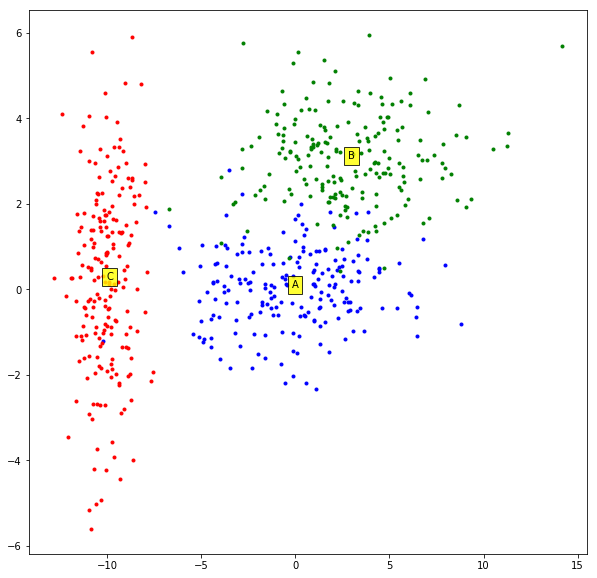

In [4]:
plt.figure(figsize=(10, 10))
colors = ('blue','green','red')
titles = ["A", "B", "C"]
for title, class_points, color in zip(titles, [a_xy, b_xy, c_xy], colors):
    plt.plot(class_points[0], class_points[1], ".", color=color)
    plt.text(x=np.mean(class_points[0]), y = np.mean(class_points[1]), s=title, bbox=dict(facecolor='yellow', alpha=0.8))
        
plt.show()

Looking at plots we can suppose that data of each class is from Gaussian distribution. Class A and B are likely to have covariance matrix close to isotropic one. Let's try to estimate parameters of this distributions.

In [5]:
titles = ["A", "B", "C"]
class_mean = []
class_cov = []

for title, class_points in zip(titles, [a, b, c]):
    class_mean.append(np.mean(class_points, axis=0))
    class_cov.append(np.cov(class_points.T))
    print(f"Class {title}:\n Mean: {class_mean[-1]},\n Covariance matrix:\n {class_cov[-1]}")

Class A:
 Mean: [-0.21000115  0.03048009],
 Covariance matrix:
 [[10.02769733  0.13162336]
 [ 0.13162336  0.83932673]]
Class B:
 Mean: [2.8018991 3.0535643],
 Covariance matrix:
 [[10.17034812  0.18023771]
 [ 0.18023771  1.0840038 ]]
Class C:
 Mean: [-10.05748461   0.22582978],
 Covariance matrix:
 [[0.97013029 0.23458112]
 [0.23458112 4.69756273]]


Using obtained parameters of dixtributions let's define discrimant function for each class.

In [6]:
def discriminant_func(x, mean, cov):
    return -1/2 * np.matmul(np.matmul((x - mean), np.linalg.inv(cov)), (x - mean)) + \
            np.log(1/np.sqrt((2 * np.pi)**(len(x))) / np.sqrt(np.linalg.det(cov)))

Comparing values of discriminant function we can assign class to new points

In [7]:
def predict_gaussian(x, class_mean, class_cov, labels):
    discriminant_values = [discriminant_func(x, mean, cov) for (mean, cov) in zip(class_mean, class_cov)]
    return labels[np.argmax(discriminant_values)]

Now, let's draw decision boundaries of obtained model

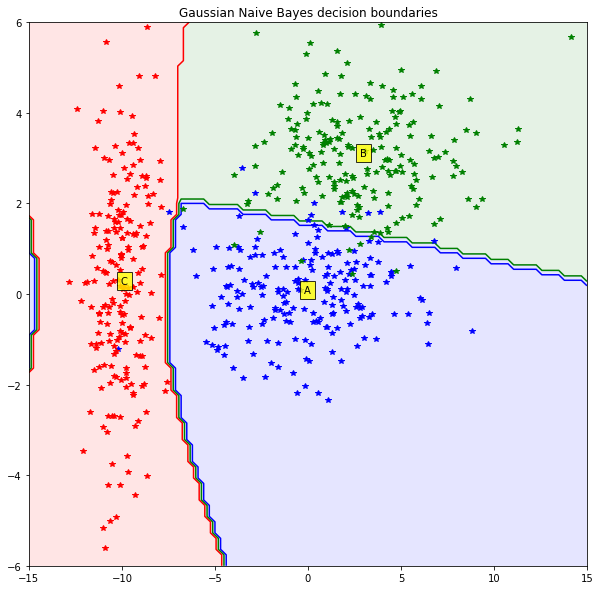

In [8]:
N = 100
X = np.linspace(-15, 15, N)
Y = np.linspace(-6, 6, N)
X, Y = np.meshgrid(X, Y)

fig = plt.figure(figsize = (10,10))
ax = fig.gca()

predictions = np.array([predict_gaussian(x, class_mean, class_cov, [0, 1, 2])
                        for x in zip(np.ravel(X), np.ravel(Y))]).reshape(X.shape)

#Plot the filled and boundary contours
ax.contourf(X, Y, predictions, 2, alpha = .1, colors=colors)
ax.contour(X, Y, predictions, 2, alpha = 1, colors=colors)

# Add axis and title
ax.set_title('Gaussian Naive Bayes decision boundaries')
for title, class_points, color in zip(titles, [a_xy, b_xy, c_xy], colors):
    ax.plot(class_points[0], class_points[1], "*", color=color)
    ax.text(x=np.mean(class_points[0]), y = np.mean(class_points[1]), s=title, bbox=dict(facecolor='yellow', alpha=0.8))
   
plt.show()

---

#### 1.1.2 Going beyond

Now just for curiosity reasons let's see how our model differ for sklearn' one. 

In [9]:
from sklearn.naive_bayes import GaussianNB

We will use [Gaussian Naive Bayes](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html) which will estimate parameters of distributions and on that basis creat model for future predictions.

In [10]:
data = np.vstack((a, b, c))
labels = [0] * len(a) + [1] * len(b) + [2] * len(c)

In [11]:
model_gaussian = GaussianNB(priors = None)
model_gaussian.fit(data, labels)

GaussianNB(priors=None, var_smoothing=1e-09)

Let's plot decision trees of fitted model to see whether it worked.

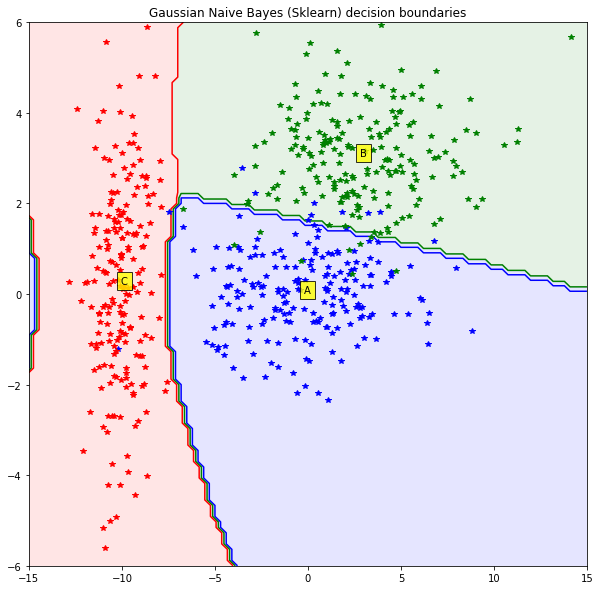

In [12]:
N = 100
X = np.linspace(-15, 15, N)
Y = np.linspace(-6, 6, N)
X, Y = np.meshgrid(X, Y)

fig = plt.figure(figsize = (10,10))
ax = fig.gca()

predictions_sklearn = np.array([model_gaussian.predict([[xx,yy]])[0]
                                for xx, yy in zip(np.ravel(X), np.ravel(Y))]).reshape(X.shape)

#Plot the filled and boundary contours
ax.contourf(X, Y, predictions_sklearn, 2, alpha = .1, colors=colors)
ax.contour(X, Y, predictions_sklearn, 2, alpha = 1, colors=colors)

# Add axis and title
ax.set_title('Gaussian Naive Bayes (Sklearn) decision boundaries')
for title, class_points, color in zip(titles, [a_xy, b_xy, c_xy], colors):
    ax.plot(class_points[0], class_points[1], "*", color=color)
    ax.text(x=np.mean(class_points[0]), y = np.mean(class_points[1]), s=title, bbox=dict(facecolor='yellow', alpha=0.8))
   
plt.show()

We see that class's regions looks like obtained above with our method. Let's estimate difference etween them.  

In [13]:
v, c = np.unique(predictions == predictions_sklearn, return_counts=True)
print(f"Our method differed from sklearn's in {c[np.where(v==False)][0] / N**2 * 100: 0.2f} % of points on grid") 

Our method differed from sklearn's in  1.14 % of points on grid


### 1.2 Mahalanobis distance
For classes `a` and `b`, give the expression of the Mahalanobis distance used to classify a point in class `a` or `b`, and verify the obtained classification, in comparison with the "complete" Bayes classification, for a few points of the plane.

To use Mahalanobis distance we need to assume that classes A and B have the same covariance matrix. Let's first take a look at them.

In [14]:
for title, cov in zip(titles, class_cov[:2]):
    print(f"Class {title}:\n Covariance matrix:\n {cov}")

Class A:
 Covariance matrix:
 [[10.02769733  0.13162336]
 [ 0.13162336  0.83932673]]
Class B:
 Covariance matrix:
 [[10.17034812  0.18023771]
 [ 0.18023771  1.0840038 ]]


To evaluate their similarity we will use Frobenius distance.

In [15]:
print(f"Frobenius distance is{np.linalg.norm(class_cov[0] - class_cov[1], ord='fro'): 0.5f}")

Frobenius distance is 0.29145


It looks like matrices are close to be similar. Thus we can use Mahalanobis distance and the most probable class will be the one which will minimize it.

In [16]:
def mahalanobis_dist(x, mean, cov):
    return np.sqrt(np.matmul(np.matmul((x - mean), np.linalg.inv(cov)), (x - mean)))

In [17]:
def predict_mahalanobis(x, class_mean, cov, labels):
    discriminant_values = [discriminant_func(x, mean, cov) for mean in class_mean]
    return labels[np.argmax(discriminant_values)]

In [18]:
class_mean = class_mean[:2] # Take only values for class A and B
class_cov = class_cov[:2] # Take only values for class A and B
cov = class_cov[0] # Assume that covariance matrices are the same

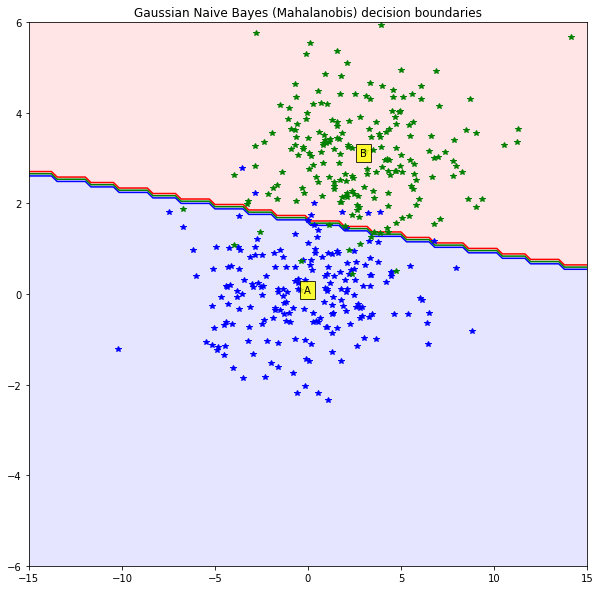

In [19]:
N = 100
X = np.linspace(-15, 15, N)
Y = np.linspace(-6, 6, N)
X, Y = np.meshgrid(X, Y)

fig = plt.figure(figsize = (10,10))
ax = fig.gca()

predictions_mahalanobis = np.array([predict_mahalanobis(x, class_mean, cov, [0, 1])
                                    for x in zip(np.ravel(X), np.ravel(Y))]).reshape(X.shape)

#Plot the filled and boundary contours
ax.contourf(X, Y, predictions_mahalanobis, 2, alpha = .1, colors=colors)
ax.contour(X, Y, predictions_mahalanobis, 2, alpha = 1, colors=colors)

# Add axis and title
ax.set_title('Gaussian Naive Bayes (Mahalanobis) decision boundaries')
for title, class_points, color in zip(titles, [a_xy, b_xy], colors):
    ax.plot(class_points[0], class_points[1], "*", color=color)
    ax.text(x=np.mean(class_points[0]), y = np.mean(class_points[1]), s=title, bbox=dict(facecolor='yellow', alpha=0.8))
   
plt.show()

Let's compare this model to "complete" Naive Bayes

In [20]:
predictions_mahalanobis = np.array([predict_mahalanobis(x, class_mean, cov, [0, 1])
                                    for x in zip(np.ravel(X), np.ravel(Y))]).reshape(X.shape)
predictions_gaussian = np.array([predict_gaussian(x, class_mean, class_cov, [0, 1])
                                    for x in zip(np.ravel(X), np.ravel(Y))]).reshape(X.shape)

We will plot regions where predictions are not the same for models

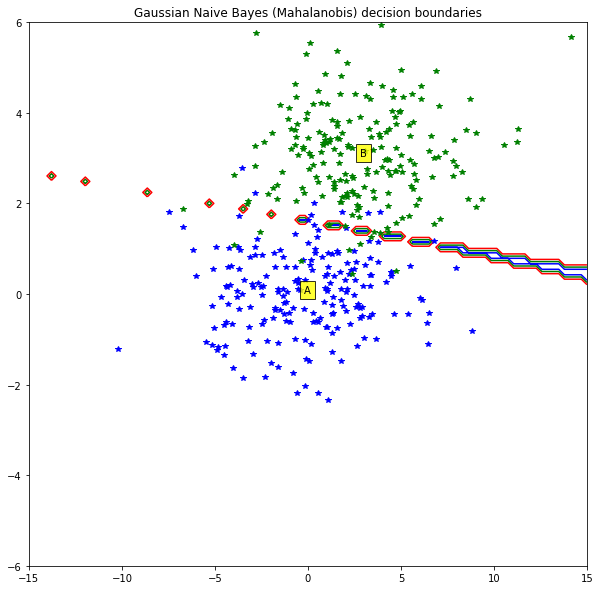

In [21]:
N = 100
X = np.linspace(-15, 15, N)
Y = np.linspace(-6, 6, N)
X, Y = np.meshgrid(X, Y)

fig = plt.figure(figsize = (10,10))
ax = fig.gca()


are_different = predictions_gaussian == predictions_mahalanobis

#Plot the filled and boundary contours
ax.contour(X, Y, are_different, 2, alpha = 1, colors=colors)

# Add axis and title
ax.set_title('Gaussian Naive Bayes (Mahalanobis) decision boundaries')
for title, class_points, color in zip(titles, [a_xy, b_xy], colors):
    ax.plot(class_points[0], class_points[1], "*", color=color)
    ax.text(x=np.mean(class_points[0]), y = np.mean(class_points[1]), s=title, bbox=dict(facecolor='yellow', alpha=0.8))
   
plt.show()

From plot we can see that there is not too much difference between obtaioned models.

## Part 2
In this part, we aim to classify digits using the complete version of MNIST digits dataset.
The dataset consists of 60'000 training images and 10'000 test images of handwritten digits.
Each image has size 28x28, and has assigned a label from zero to nine, denoting the digits value.
Given this data, your task is to construct a Multilayer Perceptron (MLP) for supervised training and classification and evaluate it on the test images.

Download the MNIST dataset (all 4 files) from http://yann.lecun.com/exdb/mnist/ under `lab-03-data/part2`.
You can then use the script provided below to extract and load training and testing images in Python.

To create an MLP you are free to choose any library.
In case you don't have any preferences, we encourage you to use the [scikit-learn] package; it is a simple, efficient and free tool for data analysis and machine learning.
In this [link][sklearn-example], you can find a basic example to see how to create and train an MLP using [scikit-learn].
Your network should have the following properties:
* Input `x`: 784-dimensional (i.e. 784 visible units representing the flattened 28x28 pixel images).
* 100 hidden units `h`.
* 10 output units `y`, i.e. the labels, with a value close to one in the i-th class representing a high probability of the input representing the digit `i`.

If you need additional examples you can borrow some code from image classification tutorials.
However, we recommend that you construct a minimal version of the network on your own to gain better insights.

[scikit-learn]: http://scikit-learn.org/stable/index.html
[sklearn-example]: http://scikit-learn.org/stable/modules/neural_networks_supervised.html

### 2.1 Dataset loading
Here we first declare the methods `extract_data` and `extract_labels` so that we can reuse them later in the code.
Then we extract both the data and corresponding labels, and plot randomly some images and corresponding labels of the training set.

In [5]:
import gzip
import numpy as np
import matplotlib.pyplot as plt

def extract_data(filename, image_shape, image_number):
    with gzip.open(filename) as bytestream:
        bytestream.read(16)
        buf = bytestream.read(np.prod(image_shape) * image_number)
        data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
        data = data.reshape(image_number, image_shape[0], image_shape[1])
    return data


def extract_labels(filename, image_number):
    with gzip.open(filename) as bytestream:
        bytestream.read(8)
        buf = bytestream.read(1 * image_number)
        labels = np.frombuffer(buf, dtype=np.uint8).astype(np.int64)
    return labels

In [6]:
image_shape = (28, 28)
train_set_size = 60000
test_set_size = 10000

data_part2_folder = os.path.join(data_base_path, data_folder, 'part2')

train_images_path = os.path.join(data_part2_folder, 'train-images-idx3-ubyte.gz')
train_labels_path = os.path.join(data_part2_folder, 'train-labels-idx1-ubyte.gz')
test_images_path = os.path.join(data_part2_folder, 't10k-images-idx3-ubyte.gz')
test_labels_path = os.path.join(data_part2_folder, 't10k-labels-idx1-ubyte.gz')

train_images = extract_data(train_images_path, image_shape, train_set_size)
test_images = extract_data(test_images_path, image_shape, test_set_size)
train_labels = extract_labels(train_labels_path, train_set_size)
test_labels = extract_labels(test_labels_path, test_set_size)

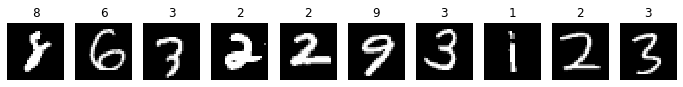

In [7]:
prng = np.random.RandomState(seed=123456789)  # seed to always re-draw the same distribution
plt_ind = prng.randint(low=0, high=train_set_size, size=10)

fig, axes = plt.subplots(1, 10, figsize=(12, 3))
for ax, im, lb in zip(axes, train_images[plt_ind], train_labels[plt_ind]):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(lb)

### 2.2 MLP

For this task we will use a very popular library for AI - [PyTorch](https://pytorch.org). First let us create a NN module using typical PyTorch pipeline.

In [13]:
import torch
from torch import nn
from torch.nn import functional as F

In [25]:
class Net(nn.Module):
    def __init__(self, nb_hidden = 100):        
        super(Net, self).__init__()
        self.fc1 = nn.Linear(784, nb_hidden)
        self.fc2 = nn.Linear(nb_hidden, 10)
    
    def forward(self, x):
        
        # input has [mini_batch_size, 784], output has [mini_batch_size, nb_hidden]
        x = F.relu(self.fc1(x))
        

        # input has [mini_barch_size, 128], output has [mini_batch_size, 10]
        x = self.fc2(x)
        
        return x

In [85]:
def train_model(model, train_inputs, train_targets, mini_batch_size=100):
    
    lr, nb_epochs, batch_size = 1e-3, 25, 100 

    optimizer = torch.optim.Adam(model.parameters(), lr = lr) 
    criterion = nn.CrossEntropyLoss()
    
    for e in range(nb_epochs):
        for train_input, train_target in zip(train_inputs.split(mini_batch_size), train_targets.split(mini_batch_size)):
            output = model(train_input)
            loss = criterion(output, train_target) 
            optimizer.zero_grad() 
            loss.backward()
            optimizer.step()
        print('%dth epoch and the loss is %f' % (e+1, loss))
            
    return model
        
def compute_nb_errors(model, tensor_inputs, targets, mini_batch_size=100):
    
    nb_errors = 0
    
    for tensor_input, target in zip(tensor_inputs.split(mini_batch_size), targets.split(mini_batch_size)):
        output = model(tensor_input)
        _, predicted_classes = output.max(1)
        nb_errors += (target != predicted_classes).sum().item()
                
    return nb_errors

In [86]:
# Creating PyTorch tensors
train_inputs, test_inputs = torch.Tensor(train_images).view(-1, 784), \
    torch.Tensor(test_images).view(-1, 784)
train_targets, test_targets = torch.Tensor(train_labels).long(), torch.Tensor(test_labels).long()

mu, std = train_inputs.mean(), train_inputs.std() 
train_inputs.sub_(mu).div_(std)

test_inputs.sub_(mu).div_(std)

model_attempt = Net()
model = train_model(model_attempt, train_inputs, train_targets)

1th epoch and the loss is 0.230975
2th epoch and the loss is 0.184008
3th epoch and the loss is 0.170603
4th epoch and the loss is 0.171133
5th epoch and the loss is 0.160571
6th epoch and the loss is 0.150550
7th epoch and the loss is 0.133688
8th epoch and the loss is 0.133898
9th epoch and the loss is 0.120945
10th epoch and the loss is 0.105372
11th epoch and the loss is 0.085593
12th epoch and the loss is 0.084326
13th epoch and the loss is 0.059032
14th epoch and the loss is 0.045076
15th epoch and the loss is 0.027730
16th epoch and the loss is 0.011176
17th epoch and the loss is 0.013683
18th epoch and the loss is 0.007650
19th epoch and the loss is 0.002935
20th epoch and the loss is 0.005157
21th epoch and the loss is 0.036651
22th epoch and the loss is 0.003264
23th epoch and the loss is 0.004815
24th epoch and the loss is 0.065425
25th epoch and the loss is 0.002855


In [87]:
nb_errors_train = compute_nb_errors(model, train_inputs, train_targets)
nb_errors_test = compute_nb_errors(model, test_inputs, test_targets)

print('Number of correct train classifications: %d out of %d\nNumber of correct test classifications: %d out of %d' % (train_inputs.size(0) - nb_errors_train, train_inputs.size(0), test_inputs.size(0) - nb_errors_test, test_inputs.size(0)))

Number of correct train classifications: 59651 out of 60000
Number of correct test classifications: 9747 out of 10000


In [88]:
# Creating PyTorch tensors
N = 1000

train_small_inputs, train_small_targets = train_inputs[:N], train_targets[:N]
test_small_inputs, test_small_targets = test_inputs[:N], test_targets[:N]

mu, std = train_small_inputs.mean(), train_small_inputs.std() 
train_small_inputs.sub_(mu).div_(std)

test_small_inputs.sub_(mu).div_(std)

small_model = Net()
small_model = train_model(small_model, train_small_inputs, train_small_targets)

1th epoch and the loss is 1.398138
2th epoch and the loss is 0.751847
3th epoch and the loss is 0.506830
4th epoch and the loss is 0.397104
5th epoch and the loss is 0.324250
6th epoch and the loss is 0.267839
7th epoch and the loss is 0.229479
8th epoch and the loss is 0.195524
9th epoch and the loss is 0.166670
10th epoch and the loss is 0.142282
11th epoch and the loss is 0.120131
12th epoch and the loss is 0.101096
13th epoch and the loss is 0.084216
14th epoch and the loss is 0.070280
15th epoch and the loss is 0.059511
16th epoch and the loss is 0.050435
17th epoch and the loss is 0.043710
18th epoch and the loss is 0.038162
19th epoch and the loss is 0.033717
20th epoch and the loss is 0.030106
21th epoch and the loss is 0.026929
22th epoch and the loss is 0.024388
23th epoch and the loss is 0.022063
24th epoch and the loss is 0.020054
25th epoch and the loss is 0.018411


In [89]:
nb_errors_small_train = compute_nb_errors(small_model, train_small_inputs, train_small_targets)
nb_errors_small_test = compute_nb_errors(small_model, test_small_inputs, test_small_targets)

print('Number of correct train classifications: %d out of %d\nNumber of correct test classifications: %d out of %d' % 
      (train_small_inputs.size(0) - nb_errors_small_train, train_small_inputs.size(0), 
       test_small_inputs.size(0) - nb_errors_small_test, test_small_inputs.size(0)))

Number of correct train classifications: 1000 out of 1000
Number of correct test classifications: 862 out of 1000


In [101]:
class ConvNet(nn.Module):
    def __init__(self, nb_hidden = 128):        
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5)
        self.fc1 = nn.Linear(256, nb_hidden)
        self.fc2 = nn.Linear(nb_hidden, 10)
        
        ## we can play by 
        ## 1. add more and different layers
        ## 2. change number of hidden unit. Actually I think here is too much for the input dimension
        ## 3. kernel size but this should fit

    def forward(self, x):
        
        # input has [mini_batch_size, 2, 14, 14], output has [mini_batch_size, 32, 5, 5]
        x = F.relu(F.max_pool2d(self.conv1(x), kernel_size=3))
        
        # input has [mini_batch_size, 32, 5, 5], output has [mini_batch_size, 64, 2, 2]
        x = F.relu(F.max_pool2d(self.conv2(x), kernel_size=2)) 
        
        # input has [mini_batch_size, 64, 2, 2], output has [mini_batch_size, 256]
        x = x.view(x.size(0), -1) ## (at least in my mind) this view should keep track of the two images

        # input has [mini_batch_size, 256], output has [mini_batch_size, nb_hidden]
        x = F.relu(self.fc1(x))
        
        # input has [mini_barch_size, 128], output has [mini_batch_size, 10]
        x = self.fc2(x)
        
        return x

In [102]:
# Creating PyTorch tensors
train_inputs_norm, test_inputs_norm = torch.Tensor(train_images).view(-1, 1, 28, 28), \
    torch.Tensor(test_images).view(-1, 1, 28, 28)
train_targets, test_targets = torch.Tensor(train_labels).long(), torch.Tensor(test_labels).long()

mu, std = train_inputs_norm.mean(), train_inputs_norm.std() 
train_inputs_norm.sub_(mu).div_(std)

test_inputs_norm.sub_(mu).div_(std)

model = ConvNet()
model = train_model(model, train_inputs_norm, train_targets)

1th epoch and the loss is 0.199295
2th epoch and the loss is 0.186384
3th epoch and the loss is 0.179852
4th epoch and the loss is 0.197421
5th epoch and the loss is 0.192886
6th epoch and the loss is 0.183221
7th epoch and the loss is 0.187806
8th epoch and the loss is 0.170953
9th epoch and the loss is 0.163914
10th epoch and the loss is 0.130018
11th epoch and the loss is 0.153780
12th epoch and the loss is 0.092454
13th epoch and the loss is 0.070254
14th epoch and the loss is 0.056236
15th epoch and the loss is 0.030152
16th epoch and the loss is 0.072445
17th epoch and the loss is 0.010866
18th epoch and the loss is 0.047035
19th epoch and the loss is 0.010987
20th epoch and the loss is 0.044193
21th epoch and the loss is 0.003695
22th epoch and the loss is 0.036799
23th epoch and the loss is 0.039153
24th epoch and the loss is 0.000451
25th epoch and the loss is 0.000381


In [103]:
nb_errors_train = compute_nb_errors(model, train_inputs_norm, train_targets)
nb_errors_test = compute_nb_errors(model, test_inputs_norm, test_targets)

print('Number of correct train classifications: %d out of %d\nNumber of correct test classifications: %d out of %d' % 
      (train_inputs_norm.size(0) - nb_errors_train, train_inputs_norm.size(0), 
       test_inputs_norm.size(0) - nb_errors_test, test_inputs_norm.size(0)))

Number of correct train classifications: 59872 out of 60000
Number of correct test classifications: 9902 out of 10000


In [105]:
# Creating PyTorch tensors
N = 1000

train_small_inputs, train_small_targets = train_inputs_norm[:N], train_targets[:N]
test_small_inputs, test_small_targets = test_inputs_norm[:N], test_targets[:N]

mu, std = train_small_inputs.mean(), train_small_inputs.std() 
train_small_inputs.sub_(mu).div_(std)

test_small_inputs.sub_(mu).div_(std)

small_model = ConvNet()
small_model = train_model(small_model, train_small_inputs, train_small_targets)

1th epoch and the loss is 1.773843
2th epoch and the loss is 0.892269
3th epoch and the loss is 0.573001
4th epoch and the loss is 0.489370
5th epoch and the loss is 0.447889
6th epoch and the loss is 0.277880
7th epoch and the loss is 0.207836
8th epoch and the loss is 0.214549
9th epoch and the loss is 0.176526
10th epoch and the loss is 0.149457
11th epoch and the loss is 0.112135
12th epoch and the loss is 0.074001
13th epoch and the loss is 0.057140
14th epoch and the loss is 0.042164
15th epoch and the loss is 0.039974
16th epoch and the loss is 0.033013
17th epoch and the loss is 0.022336
18th epoch and the loss is 0.022461
19th epoch and the loss is 0.019622
20th epoch and the loss is 0.013259
21th epoch and the loss is 0.012409
22th epoch and the loss is 0.042580
23th epoch and the loss is 0.015551
24th epoch and the loss is 0.030120
25th epoch and the loss is 0.008867


In [106]:
nb_errors_small_train = compute_nb_errors(small_model, train_small_inputs, train_small_targets)
nb_errors_small_test = compute_nb_errors(small_model, test_small_inputs, test_small_targets)

print('Number of correct train classifications: %d out of %d\nNumber of correct test classifications: %d out of %d' % 
      (train_small_inputs.size(0) - nb_errors_small_train, train_small_inputs.size(0), 
       test_small_inputs.size(0) - nb_errors_small_test, test_small_inputs.size(0)))

Number of correct train classifications: 1000 out of 1000
Number of correct test classifications: 931 out of 1000


Pretty good I would say.